<a href="https://colab.research.google.com/github/ram130849/object_detection_using_faster_rcnn/blob/main/Object_Detection_Using_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q -U opencv-python

In [50]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import utils
from torch.utils.data import DataLoader,Dataset
from skimage import io, transform
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tqdm
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/ExDark.zip' -d '/content/gdrive/MyDrive/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/ExDark/Motorbike/2017_07361.jpg  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark/Motorbike/._2017_07361.jpg  
  inflating: /content/gdrive/MyDrive/ExDark/Motorbike/2015_06160.jpg  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark/Motorbike/._2015_06160.jpg  
  inflating: /content/gdrive/MyDrive/ExDark/Motorbike/2015_05864.jpg  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark/Motorbike/._2015_05864.jpg  
  inflating: /content/gdrive/MyDrive/ExDark/Motorbike/2015_05870.jpg  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark/Motorbike/._2015_05870.jpg  
  inflating: /content/gdrive/MyDrive/ExDark/Motorbike/2015_05858.jpg  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark/Motorbike/._2015_05858.jpg  
  inflating: /content/gdrive/MyDrive/ExDark/Motorbike/2015_05874.jpg  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark/Motorbike/._2015_05874.jpg  
  inflating: /content/gdrive/My

In [ ]:
!unzip '/content/gdrive/MyDrive/ExDark_Annno.zip' -d '/content/gdrive/MyDrive/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05787.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05787.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05797.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05797.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05933.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05933.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05923.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05923.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05951.jpg.txt  
  inflating: /content/gdrive/MyDrive/__MACOSX/ExDark_Annno/Motorbike/._2015_05951.jpg.txt  
  inflating: /content/gdrive/MyDrive/ExDark_Annno/Motorbike/2015_05829.jpg.txt  
  i

In [ ]:
BATCH_SIZE=128
num_epochs=100
lr=0.0001
class_size=10

In [ ]:
import math

'''
    x = ((width- kernel_size +2P) /S )+1
    where P = padding
          S = strides
'''

# S=2,P=1,kernel_size=3

block1 = 224
pool1 = math.ceil((block1-3)/2+1)
print(pool1)


block2 = pool1
pool2 =math.ceil((block2-3)/2 +1)
print(pool2)


block3=pool2
pool3 =math.ceil((block3-3)/2 +1)
print(pool3)


block4=pool3
pool4 =math.ceil((block4-3)/2 +1)
print(pool4)


block5=pool4
pool5 =math.ceil((block5-3)/2 +1)
print(pool5)


flatten= pool5 * pool5 * 512
print(f'After flatten:: {flatten}')

112
56
28
14
7
After flatten:: 25088


In [ ]:
class_dict = {1:'Bicycle',2:'Boat',3:'Bottle',4:'Bus',5:'Car',6:'Cat',7:'Chair',8:'Cup',9:'Dog',10:'Motorbike',11:'People',12:'Table'}
light_dict = {1:'Low',2:'Ambient',3:'Object',4:'Single',5:'Weak',6:'Strong',7:'Screen',8:'Window',9:'Shadow',10:'Twilight'}
in_out_dict = {1:'Indoor',2:'Outdoor'}
train_val_test = {1:'train',2:'val',3:'test'}

In [ ]:
classes = [val.lower() for val in list(class_dict.values())]
print(list(class_dict.keys())[list(class_dict.values()).index('Bicycle')])

1


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/imageclasslist.txt',sep=' ',header=None,skiprows=1)
df.columns = ['Name','Class','Light','In/Out','Train/Val/Test']

In [ ]:
df.loc[df.Class==1,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[1] + '/' +  df['Name']
df.loc[df.Class==2,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[2] + '/' +  df['Name']
df.loc[df.Class==3,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[3] + '/' +  df['Name']
df.loc[df.Class==4,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[4] + '/' +  df['Name']
df.loc[df.Class==5,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[5] + '/' +  df['Name']
df.loc[df.Class==6,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[6] + '/' +  df['Name']
df.loc[df.Class==7,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[7] + '/' +  df['Name']
df.loc[df.Class==8,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[8] + '/' +  df['Name']
df.loc[df.Class==9,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[9] + '/' +  df['Name']
df.loc[df.Class==10,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[10] + '/' + df['Name']
df.loc[df.Class==11,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[11] + '/' +df['Name']
df.loc[df.Class==12,'Name'] = '/content/gdrive/MyDrive/ExDark/' + class_dict[12] + '/' +df['Name']

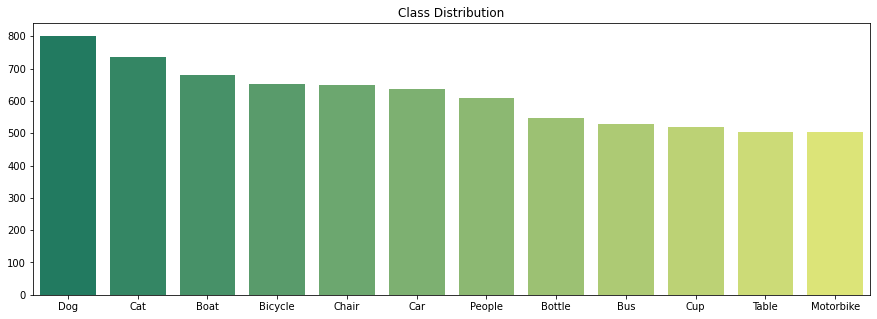

In [ ]:
class_labels = dict(df['Class'].value_counts())
labels = []
count = []
for i,j in class_labels.items():
    labels.append(class_dict[i])
    count.append(j)
plt.figure(figsize=(15,5))
sns.barplot(x=labels,y=count,palette='summer')
plt.title('Class Distribution')
plt.show()

In [ ]:
def get_class_analysis(label):
    global df
    df1 = df[df['Class']==label]
    in_out = dict(df1['In/Out'].value_counts())
    light_cond = dict(df1['Light'].value_counts())
    in_out_label =[]
    in_out_cnt =[]
    for i,j in in_out.items():
        in_out_label.append(in_out_dict[i])
        in_out_cnt.append(j)
    light_label = []
    light_cnt = []
    for i,j in light_cond.items():
        light_label.append(light_dict[i])
        light_cnt.append(j)
    print('In/Out Distribution:',in_out_label,in_out_cnt)
    print('Lightning Condt Distribution:',light_label,light_cnt)
    fig,axis = plt.subplots(2,1,figsize=(10,10))
    axis1 = sns.barplot(x=in_out_label,y=in_out_cnt,ax=axis[0])
    axis1.set_title('Indoor/outdoor Distribution')
    axis2 = sns.barplot(x=light_label,y=light_cnt,ax=axis[1])
    axis2.set_title('Lighting Condition Distribution')
    plt.show()

In/Out Distribution: ['Outdoor', 'Indoor'] [627, 25]
Lightning Condt Distribution: ['Strong', 'Ambient', 'Object', 'Weak', 'Single', 'Twilight', 'Shadow', 'Window', 'Low'] [326, 109, 64, 56, 50, 28, 8, 6, 5]


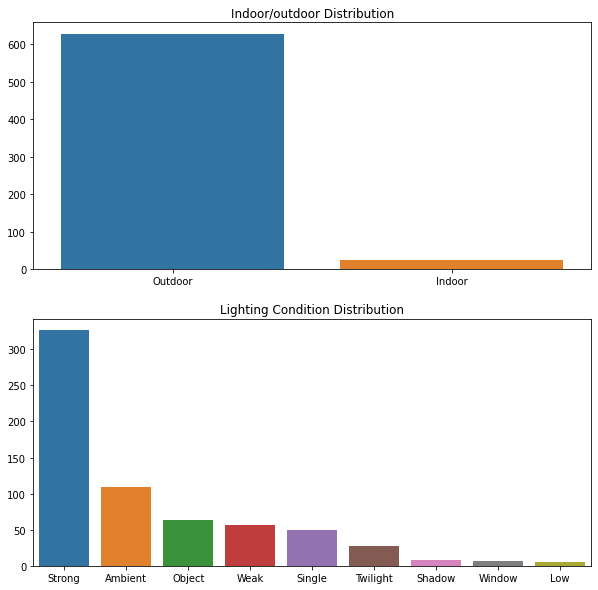

In [ ]:
get_class_analysis(1)

In/Out Distribution: ['Outdoor', 'Indoor'] [676, 3]
Lightning Condt Distribution: ['Strong', 'Twilight', 'Ambient', 'Weak', 'Single', 'Object', 'Shadow', 'Low'] [277, 254, 73, 38, 24, 5, 5, 3]


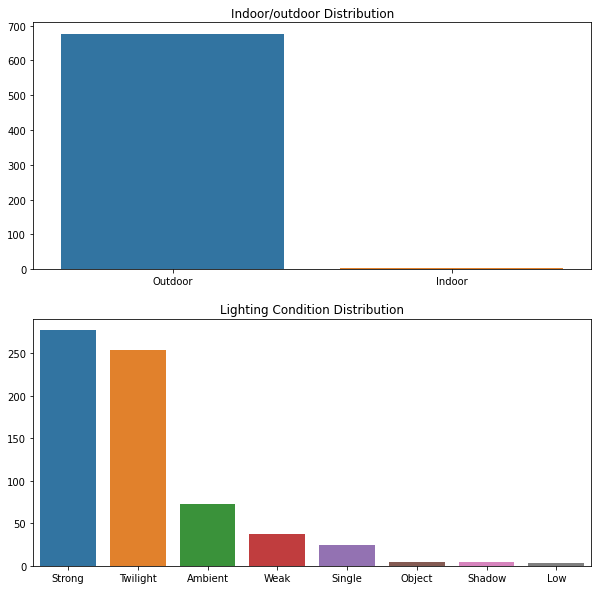

In [ ]:
get_class_analysis(2)

In/Out Distribution: ['Indoor', 'Outdoor'] [438, 109]
Lightning Condt Distribution: ['Ambient', 'Single', 'Weak', 'Object', 'Strong', 'Low', 'Screen', 'Window', 'Twilight', 'Shadow'] [172, 100, 65, 61, 59, 39, 30, 13, 6, 2]


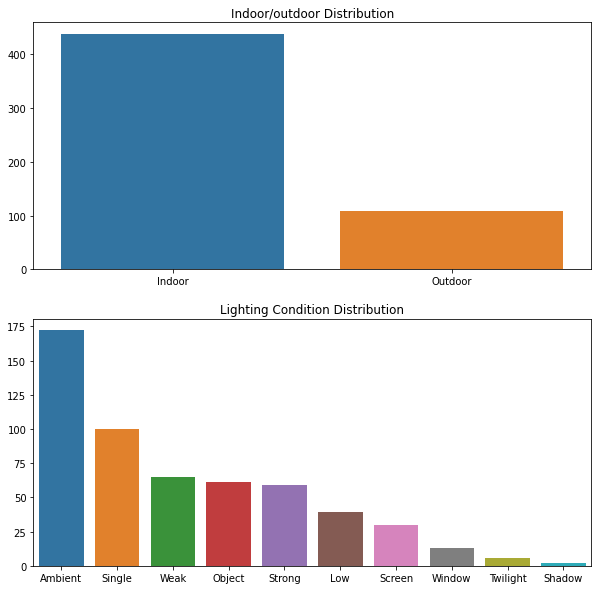

In [ ]:
get_class_analysis(3)

In [ ]:
def plot_sample_images(label,n):
      images = []
      light = []
      global df
      df2 = df[df['Class']==label]

      for i in range(1,11):
          temp = list(df2[df2['Light']==i]['Name'])[0:n]
          if(len(temp)>2):
              for j in temp:
                  light.append(i)
                  images.append(j)

      fig, ax = plt.subplots(len(images)//n,n,figsize=(15,30),gridspec_kw={'wspace':0.01,'hspace':0.1})
      ax = ax.ravel()

      for i, img in enumerate(images):
          im_org = cv2.imread(img)
          try:
              im_resized = cv2.resize(im_org,(300,300),interpolation=cv2.INTER_LINEAR)
          except:
              continue
          ax[i].imshow(cv2.cvtColor(im_resized,cv2.COLOR_BGR2RGB),aspect='auto')
          ax[i].set_axis_off()
          ax[i].set_xlim(ax[i].get_xlim())
          ax[i].set_ylim(ax[i].get_ylim())
          ax[i].set_title(class_dict[label] + "/" + light_dict[light[i]])
      
      plt.show()

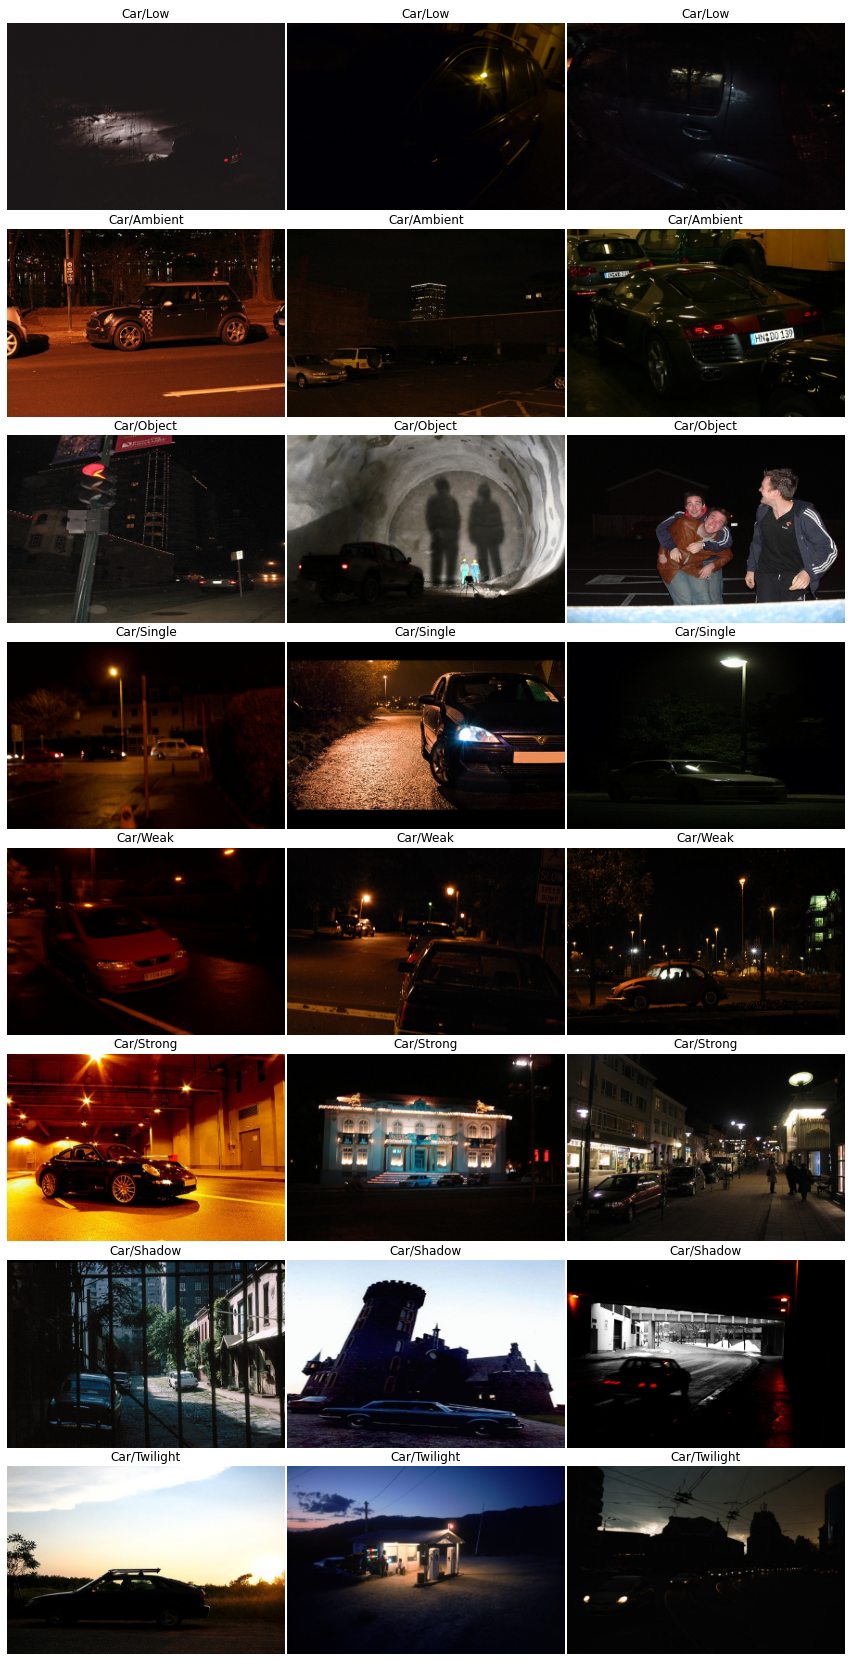

In [ ]:
plot_sample_images(5,3)

In [ ]:
os.chdir('/content/gdrive/MyDrive/ExDark_Annno/')
DIRS = os.listdir(os.getcwd())
print(DIRS)

['Cat', 'Car', 'Cup', 'Dog', 'Boat', 'Chair', 'Bus', 'Motorbike', 'Table', 'People', 'Bicycle', 'Bottle']


In [ ]:
for dir in DIRS:
    dir = '/content/gdrive/MyDrive/ExDark_Annno'+ '/' + dir
    if(os.path.isdir(dir)):
        os.chdir(dir)
        for filename in tqdm.tqdm(os.listdir(os.getcwd())):
            filename_str = str.split(filename, ".")[0]
            if filename.endswith(".txt"):
                  annotations = []
                  with open(filename) as f:
                      for idx,val in enumerate(f):
                          if(idx==0):
                            continue
                          class_label = val.split()[0]
                          if(class_label.lower() not in classes):
                            continue
                          val = val.replace(class_label,str(list(class_dict.keys())[list(class_dict.values()).index(class_label)]))
                          labels = val.split()
                          coords = np.asarray([float(labels[1]),float(labels[2]),float(labels[3]),float(labels[4])])
                          labels[1],labels[2],labels[3],labels[4] = coords[0], coords[1], coords[2], coords[3]
                          new_val = str(labels[0]) + " " + str(labels[1]) + " " +str(labels[2]) + " " + str(labels[3]) + " " + str(labels[4])
                          val = val.replace(val, new_val)
                          annotations.append(val)
                      f.close()
                  with open(filename,'w') as outfile:
                      for val in annotations:
                          outfile.write(val)
                          outfile.write('\n') 
                      outfile.close()       
        os.chdir('..')

100%|██████████| 547/547 [00:03<00:00, 138.82it/s]


In [ ]:
class ExDark(Dataset):
    def __init__(self,data,transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __get_item__(self,idx):
        if(torch.is_tensor(idx)):
            idx = idx.tolist()
        
        pass

In [ ]:
tranform_train = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train = ExDark()


train_loader = DataLoader(train,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
class VGG16Net(nn.Module):
    def __init__(self):
        super(VGG16Net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.conv6 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        self.conv7 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        self.conv8 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096,4096)
        self.fc16 = nn.Linear(4096,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = VGG16Net() 
model = model.to(device=device) 
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr) 

In [ ]:
for epoch in range(num_epochs):
    loss_var = 0
    for idx,(image,labels) in enumerate(train_loader):
      
        

In [ ]:
torch.save(model.state_dict(), "vgg16_model.pt") #SAVES THE TRAINED MODEL
model = VGG16Net()
model.load_state_dict(torch.load("vgg16_model.pt")) #loads the trained model
model.eval()

VGG16Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3, 

In [51]:
class Object_Detector(Module):
    def __init__(self,base_model,no_classes):
        super(Object_Detector,self).__init__()
        self.base_model = base_model
        self.no_classes = no_classes
        self.regressor = Sequential(
            Linear(self.base_model.fc.in_features,128),
            ReLU(),
            Linear(128,64),
            ReLU(),
            Linear(64,32),
            ReLU(),
            Linear(32,4)
        )
        self.classifier = Sequential(
            Linear(self.base_model.fc.in_features,512),
            ReLU(),
            Dropout(),
            Linear(512,256),
            ReLU(),
            Dropout(),
            Linear(256,self.no_classes)
        )
        ### The final step of the initialization is to make the base model’s fully connected layer into an Identity layer,
        ### which means it’ll mirror the outputs produced by the convolution block right before it
        self.base_model.fc = Identity()

    def forward(self,x):
        features = self.base_model(x)
        b_boxes = self.regressor(features)
        class_logits = self.classifier(features)

        return (b_boxes,class_logits)

In [55]:
class Residual_Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Residual_Block, self).__init__()
        self.num_layers = num_layers
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if(self.num_layers > 34):
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if(self.identity_downsample):
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [58]:
class ResNet(nn.Module):
    def __init__(self, no_layers, block, image_channels, num_classes):
        assert no_layers in [18, 34, 50, 101, 152], ' Number of layers has to be 18, 34, 50, 101, or 152'
        super(ResNet, self).__init__()
        self.expansion = 4
        layers = [3, 4, 23, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 56

        # ResNetLayers
        self.layer1 = self.make_layers(no_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(no_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(no_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(no_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [61]:
backbone = ResNet(101, Residual_Block, 3, 1000)
print(backbone.eval())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Residual_Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, 